# MODULE 4: Modeling Workflow
In this module, we cover the modeling workflow from defining the model, running simulations, evaluating the model, and using it for optimization. The learning outcomes of this module are:

* Understand modeling workflow, with an ability to provide a detailed case example
* Be able to use a reinforcement learning model of multitasking while driving
* Be able to use Bayesian likelihood free inference to fit model parameters
* Understand how parameterized simulation models can be used to explore design candidates

Why workflow? 1. Clear plan (knowing what to do, avoiding hacks). 2. Reproducability (clarity, transparency)

The workflow used in this notebook can be illustrated like this.

<br><br>

<div>
<img src="https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/main/04-Workflow/workflow.png" width="800">
</div>

Please note that this is not a general workflow that can be used to describe every model, but a description of the process of this notebook. For a more general theory of modeling workflow, you can read this Wilson & Collins 2019 paper: https://elifesciences.org/articles/49547

**Note**. The word "model" has multiple meanings. A model can refer to the whole interactive task, including the user, or it can refer to just the user's cognition, or it can even refer to a specific internal model that the user has of the task. In this notebook, from now on, we will be using the following exact (but narrow) definitions.

* An *agent* takes actions to reach goals.
* The agent utilises a *policy*, which tells what the agent does in a particular state.
* The agent is expected to follow a *bounded optimal policy*, meaning it generally does what is best for it in the long term.
* The agent interacts with an *environment*, which for our computational is formalised. The resulting interaction of the formalised environment and the agent is called *simulation* of the interactive task.
* The agent has an internal representation of the dynamics of the environment. Here, we call that a *model*, which, given the current state of the environment and an action taken by the agent, provides a prediction of what the next state will be.  

## Case: Multitasking while Driving
The module will make use of a computational cognitive model that simulates driver multitasking (Jokinen, Kujala, & Oulasvirta 2021: https://journals.sagepub.com/doi/10.1177/0018720820927687

The model architecture takes the form of hierarchical control system, where different parts of the hierarchy are responsible for managing one part of the overall task. As illustrated above, the task is accomplished by three components.

<div>
<img src="https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/main/04-Workflow/driving.png" width="500">
</div>

Each "box" is its own RL agent, responsible only for its own task: driving (the primary task), in-car visual search (the secondary task), or supervision (deciding which task to attend). The isolation of these agents makes it possible to define each one separately from all others. Next, we define the driving task by following the modeling workflow outlined in the figure. Appendix 1 contains a walkthrough of how to create the full task model.

Driving in a naturalistic setting is a complicated task, which involves a large number of relevant environmental features, such as details about the road, other traffic, pedestrians, street signs, driving speed, orientation of the steering wheel, amount of fuel left, etc. In order to simplify the task into a manageable simulation, we here reduce the task to its simplest form. We define driving as a control task, where the car has a position on the lane. Depending on the speed $S$ of the car and angle of the steering wheel $\omega$, the next position $x$ of the car on the lane is dictated by its previous position.

$$ x_{t+1} = x_t + sin(\omega) \cdot S \cdot \tau, $$

where $\tau$ is a constant indicating the length of one tick of the simulation in seconds.

We can then define the driver *agent*. At any time step $t$ the agent can take actions $\omega_t \in [\omega_{min},\omega_{max}]$ to steer the car. It receives a real-valued reward based on the position of the car on the lane: if the position at a time step $x_t$ is less than $x_min$ or more than $x_max$, the agent receives a negative reward. Otherwise it receives a reward of zero.

We can now implement a simplified version of the driving environment and agent. Please note that this is not the full model, but is used here for demonstrative purposes.

In [15]:
# Run this block of code first if you are on Colab!
! wget https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/main/04-Workflow/driver.py
! wget https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/main/04-Workflow/driver_agent.py
! wget https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/main/04-Workflow/driver_env.py
! wget https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/main/04-Workflow/search.py
! wget https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/main/04-Workflow/search_agent.py
! wget https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/main/04-Workflow/multitasking.py
! wget https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/main/04-Workflow/multitasking_agent.py
! wget https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/main/04-Workflow/precomputed_pred.py
! wget https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/main/04-Workflow/run_experiment.py
    
! pip install stable_baselines3
! pip install elfi

^C


In [ ]:
# Implement the driver from the scratch
from gym import Env
from gym.spaces import Discrete, Box
import math
import numpy as np
import matplotlib.pyplot as plt

class driver(Env):
    def __init__(self, speed = 17, oob_reward = -1):
        self.speed = speed # m/s
        self.oob_reward = oob_reward # reward from lane violation
        
        self.threshold = 0.2 # oob
        
        self.step_time = 0.1 # seconds
        
        # Steering wheel extrema
        self.max_steer = 0.025
        # How many discrete steering actions
        self.actions = 10
        # Action related noise
        self.action_noise = 0
        
        # Steering noise
        self.steer_noise = 0
        
        self.action_space = Discrete(self.actions)
        
        # Observe current lane position
        self.observation_space = Box(low=0, high=1, shape = (1,))
        
        self.log = False
        
        self.reset()
        
    def reset(self):
        self.x = 0.5 # in the middle of the lane
        self.time = 0
        self.trace = {}
        self.trace["action"] = []
        self.trace["x"] = []
        return [self.x]
    
    # Given a discrete action, return a true steering position
    def action_to_steer(self, action):
        a = self.action_space.n/2
        return (action-a)*self.max_steer/a
    
    def update_car_pos(self, action):
        steer = self.action_to_steer(action)
        # Add action related noise
        steer += abs(steer)*np.random.logistic(0, self.action_noise)
        # Add non-action related noise.
        steer += np.random.logistic(0, self.steer_noise)

        # Limit steer
        steer = min(max(steer, -self.max_steer), self.max_steer)
        self.x += math.sin(steer) * self.speed * self.step_time
        
    def step(self, action):
        done = False
        
        self.update_car_pos(action)
        
        if self.log:
            self.trace["action"].append(action)
            self.trace["x"].append(self.x)
        
        if self.x < self.threshold or self.x > 1 - self.threshold:
            reward = self.oob_reward
        else:
            reward = 0
            
        # Limit x
        self.x = max(min(self.x,1),0)

        return [self.x], reward, done, {}
    
    def plot_trace(self):
        plt.close()
        plt.ylim(0,1)
        ax = plt.gca()
        ax.invert_yaxis()
        oob = np.greater(self.trace["x"], 1 - self.threshold) + np.greater(self.threshold, self.trace["x"])
        t = np.linspace(0,len(self.trace["x"])*self.step_time, len(self.trace["x"]))
        plt.scatter(t, self.trace["x"], c = oob)
        
    def summarize_trace(self):
        ret = {}
        ret["sd"] = np.std(self.trace["x"])
        outside = np.sum(np.greater(self.trace["x"], 1 - self.threshold))
        outside += np.sum(np.greater(self.threshold, self.trace["x"]))

        ret["oob"] = outside / len(self.trace["x"])
        
        ret["sd_of_action"] = np.std(self.trace["action"])
        
        return ret
    

In [ ]:
# Let's try the driving task!

d = driver(17)
d.log = True
d.reset()
for i in range(10):
    d.step(1) # hard left steer
for i in range(10):
    d.step(9) # hard steer right
for i in range(10):
    d.step(5) # drive straight

d.plot_trace()
d.summarize_trace()

Now that a very simple driving environment and agent have been defined, we can train a RL model. We'll use PPO for faster convergence than the original paper, which used tabular Q learning.

In [ ]:
from stable_baselines3 import PPO
d.log = False
d_agent = PPO("MlpPolicy", d, verbose = 0)

d_agent.learn(total_timesteps = 10000) # This is going to take a couple of seconds.

In [ ]:
# Produce a trace from the agent.
def simulate_driver(driver, agent, timesteps = 1000):
    driver.log = True
    state = driver.reset()
    for i in range(timesteps):
        action, _ = agent.predict(state)
        state , _, _, _ = driver.step(action)
    driver.plot_trace()
    driver.log = False
    return driver.summarize_trace()

In [ ]:
simulate_driver(d, d_agent)

## Introducing Bounds

Now that the environmental dynamcis and the agent's goals and available actions have been defined, we can ask: how to make the RL agent behave more like a human? To that end, we should specify bounds.

We start with action related noise: larger steering wheel angles are associated with more noise. 

In [ ]:
d = driver(17)
d.action_noise = 0.02
d.steer_noise = 0.02
d_agent = PPO("MlpPolicy", d, verbose = 0)

d_agent.learn(total_timesteps = 50000) # This is going to take about 60 seconds.
simulate_driver(d, d_agent)

In [ ]:
import run_experiment
import multitasking_agent

# Forward Modeling

Now that we have defined the full model architecture for multitasking while driving, we can use it to produce simulated results and evaluate the face-validity of these results. We will be focusing on two face-valid hypotheses. First, increasing driving speed should result in shorter in-car glance duration. Second, prioritising driving safety should result in more time spent driving at the cost of the secondary task.

In [ ]:
params = {"speed": 17,
          "obs_prob": 0.8,
          "an": 0.01,
          "sn": 0.02,
          "or": -1,
          "cols": 3,
          "rows": 3,
          "fr": 10}

# Running this will take about 10 minutes.
trace = multitasking_agent.summarise_trace(run_experiment.run_experiment(params, 1200, max_iters = 20))
print(trace)

In [ ]:
print(trace)

# 3. Inference

*Parameter inference* refers to identifying values that are theoretically plausible and lead to realistic predictions. This is an *inverse modeling* problem: given observed behaviour, what are the plausible parameter values? In forward modeling, we pass a set of parameters $\theta$ to a model $M$, which then outputs data predictions $D_p$. In inverse modeling, we have observed read data $D_o$, and the goal is to find out a plausible set of parameters $\theta$, that with the model produce predictions that are close to the observations.  

<div>
<img src="inverse.png" width="200">
</div>

An in-press book chapter by Jokinen et al. https://www.jyu.fi/it/fi/tiedekunta/henkilosto/henkilosto/jokinen-jussi/jokinen-2021-bayesian.pdf has a thorough explanation of inverse modeling and Bayesian inference for cognitive models in HCI. Another paper by Kangasrääsiö et al https://onlinelibrary.wiley.com/doi/pdf/10.1111/cogs.12738 provides in-depth walkthroughs on how to infer parameters of cognitive models. Here, we will briefly cover the main points.

The main reason for using Bayesian parameter inference for inverse modeling over other possible approaches is that it provides a mathematically rigorous framework for evaluating the plausibility of different parameter values. Bayesian parameter inference is grounded on the fact that we generally cannot know the exact parameter values that best describe the observed data and user(s) behind it. However, it is possible to obtain information about the parameter values, and this information can be represented as a probability distribution over the possible parameter values. Possible information about parameters $\theta$ includes both what can be learned based on observations $D_o$, and our expectations about plausible parameter values based on what we know about the simulator model.

The idea is to express, prior to making observations, what we know about the parameters as a distribution $P(\theta)$, and then make observations to update this expectation.
Given the prior probabilities $P(\theta)$ and observation likelihood $P(D_o|\theta)$, posterior probabilities are defined as

$$
  P(\theta \mid D_O) = \frac{P(D_O \mid \theta) P(\theta)}{P(D_O)},
$$

where $P(D_o)$ is the marginal likelihood $P(\theta)=\int P(D_o|\theta)P(\theta)d\theta$. The posterior $P(\theta|D_o)$ is a probability distribution over parameter values, and it represents what we know about the unknown parameters when we take into account that these parameters produced the observations $\D_o$.

We will be using Bayesian likelihood-free parameter inference using the ELFI package (https://elfi.readthedocs.io/en/latest/). 

## Inferring Individual Driving Ability 

The model for multitasking while driving contains multiple parameters. Most of them are specified based on the description of the task environment (e.g., speed), some are based on literature (e.g., eye movement times), but some can be used to describe individuals. For instance, action related noise can be argued to be a parameter, that varies in the population. Perhaps age, or motor control problems, are associated with it. Or, it could simply be that more experienced drivers have less noisy behaviours.

Again, we start with the simple driving model created. For the purposes of this execrise, we will be using simulated data, not data from real humans.

Progress [==================================================] 100.0% Complete


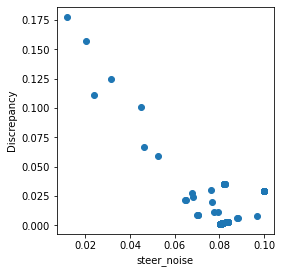

In [11]:
import elfi
import scipy
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

seed = 1
np.random.seed(seed)

import precomputed_pred
data = precomputed_pred.data

# Use parametrised RL model of driving to generate summaries.
# Optionally, supply a precomputed dataset that maps parameter 
# values to summaries.
def generate_driving_data(steer_noise, batch_size = 1, random_state = None):
    if data:
        arr = np.array(list(data.keys()))        
        d_pred = data[arr[np.abs(arr - steer_noise[0]).argmin()]] # find closest match
    else:
        d_agent = PPO("MlpPolicy", d, verbose = 0)
        d = driver(17)
        d.action_noise = 0.02 # use default for this exercise
        d.steer_noise = steer_noise
        d_agent = PPO("MlpPolicy", d, verbose = 0)
        d_agent.learn(total_timesteps = 10000)
        d_pred = simulate_driver(d, d_agent)
    return d_pred
    
# Create the ELFI model
elfi.new_model()
# Almost uninformed prior
steer_noise = elfi.Prior(scipy.stats.uniform, 0, 0.1)
# Observations. We use imaginary observations, but in reality this would be human data.
obs_a = {'sd': 0.15,
         'oob': 0.01,
         'sd_of_action': 3.0}
obs_b = {'sd': 0.21,
         'oob': 0.02,
         'sd_of_action': 3.5}

# The ELFI model
Y = elfi.Simulator(generate_driving_data, steer_noise, observed = obs_b)

# Summary statistics. As our data are already summarised, return it.
# If either/both observed and predicted data were not summarised,
# we would do that here.
def sd_of_x(d):
    return d["sd"]

S1 = elfi.Summary(sd_of_x, Y)
d = elfi.Distance('euclidean', S1)

bolfi = elfi.BOLFI(d, batch_size=1, initial_evidence=20,update_interval=10,
                       bounds={'steer_noise':(0,0.1)}, seed = seed)


bolfi.fit(n_evidence=100)

bolfi.plot_discrepancy();


The figure above shows us the discrepancy between the observed and simulated data, with smaller values indicating a better fit. The fitted ELFI model can now be sampled in order to produce a posterior for the parameter. While the discrepancy illustrated above can already be used to inspect the most plausible parameter values, the posterior provides us with a way to assess our confidence in this inference, as well as incorporate the prior.  

4 chains of 500 iterations acquired. Effective sample size and Rhat for each parameter:
steer_noise 851.7019263001401 1.0027007941936623


array([<AxesSubplot:xlabel='steer_noise'>], dtype=object)

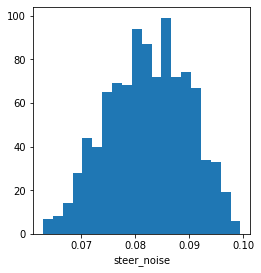

In [12]:
# Obtain a sample of the posterior
result = bolfi.sample(500, info_freq=500)

result.plot_marginals()

This posterior can be freely analysed. A point estimate, such as mean, median, or mode, can be used to set the most plausible parameter value, i.e., the value that best produces the observed behaviour, when used to parametrize the simulation model. Entropy or standard deviation can be used to assess our confidence in that point estimate, which should therefore not be used "blindly" as the best fit. Finally, one can sample the posterior for multiple values for the parameter, and use this sample to generate a range of predictions form the simulation model. The resulting *posterior predictive distribution* is useful in predicting the range of behaviours, given the inference.

In [13]:
print(np.mean(result.samples['steer_noise']))
print(np.median(result.samples['steer_noise']))
print(np.std(result.samples['steer_noise']))

0.08237565360942864
0.08239855556872466
0.007526371697904383


# Application